# EDA METADATA

## Initialization

In [1]:
# 1) Install GCS connector
!pip install -q gcsfs

# 2) Auth to your Google account
from google.colab import auth
auth.authenticate_user()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Dataset

In [3]:
df = pd.read_csv('gs://ucm_tfm_datos_carlotatrigo/metadata.csv')
df.head()

,image_id,origin_dataset,lesion_type,diagnosis,body_region,age,gender
0,ISIC_0000000.jpg,ISIC2019,benign,NV,anterior torso,55,female
1,ISIC_0000001.jpg,ISIC2019,benign,NV,anterior torso,30,female
2,ISIC_0000002.jpg,ISIC2019,malignant,MEL,upper extremity,60,female
3,ISIC_0000003.jpg,ISIC2019,benign,NV,upper extremity,30,male
4,ISIC_0000004.jpg,ISIC2019,malignant,MEL,posterior torso,80,male


In [4]:
df.shape

(71715, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71715 entries, 0 to 71714
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_id        71715 non-null  object
 1   origin_dataset  71715 non-null  object
 2   lesion_type     71715 non-null  object
 3   diagnosis       71715 non-null  object
 4   body_region     71715 non-null  object
 5   age             71715 non-null  object
 6   gender          71715 non-null  object
dtypes: object(7)
memory usage: 3.8+ MB


In [6]:
# As expected, there are no NaNs. They are corrected during the database creation step.
df.isna().sum()

,0
image_id,0
origin_dataset,0
lesion_type,0
diagnosis,0
body_region,0
age,0
gender,0


# Exploratory Data Analysis

## Age

In [7]:
df['age'] = pd.to_numeric(df['age'], errors='coerce')

df['age'] = df['age'].replace('not_provided', np.nan)
# df['age'] = df['age'].replace(np.nan, 'not_provided')
# df['age'] = df['age'].replace('Unknown', 'not_provided')

In [8]:
df['age'].describe()

,age
count,70872.000000
mean,52.613924
std,16.536828
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,90.000000


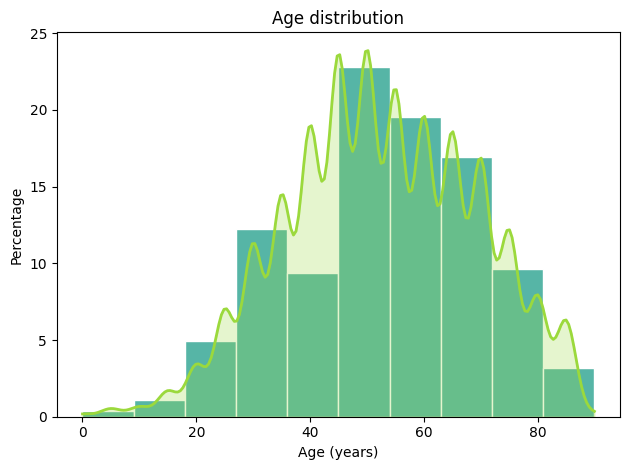

In [9]:
# Clean ages
age = pd.to_numeric(df['age'], errors='coerce').dropna()
age = age[(age >= 0) & (age <= 120)]

# Colors from viridis
c_hist = plt.cm.viridis(0.55)
c_kde  = plt.cm.viridis(0.85)

plt.figure()
ax = sns.histplot(age, stat='percent', bins=10, kde=True,
                  color=c_hist, edgecolor='white', alpha=0.75)

# Shade the KDE
if ax.lines:
    x = ax.lines[0].get_xdata()
    y = ax.lines[0].get_ydata()
    ax.lines[0].set_color(c_kde)
    ax.lines[0].set_linewidth(2)
    ax.fill_between(x, y, color=c_kde, alpha=0.25)

ax.set_title('Age distribution')
ax.set_xlabel('Age (years)')
ax.set_ylabel('Percentage')
plt.tight_layout()
plt.show()

## Localization

In [11]:
df['body_region'].unique()

array(['anterior torso', 'upper extremity', 'posterior torso',
       'lower extremity', 'not_provided', 'lateral torso', 'head/neck',
       'palms/soles', 'trunk', 'chest', 'back', 'abdomen', 'foot', 'face',
       'neck', 'scalp', 'genital', 'hand', 'ear', 'acral',
       'upper_extremity', 'oral/genital', 'torso', 'head_neck_face',
       'lower_extremity', 'left arm - lower', 'right leg - lower',
       'left leg - upper', 'right arm - lower', 'left leg - lower',
       'right arm - upper', 'right leg - upper', 'left arm - upper',
       'right arm', 'left leg', 'left arm', 'right leg'], dtype=object)

In [13]:
loc_map = {
    # trunk
    'anterior torso':'trunk','posterior torso':'trunk','lateral torso':'trunk',
    'trunk':'trunk','torso':'trunk','chest':'trunk','back':'trunk','abdomen':'trunk',

    # upper extremity
    'upper extremity':'upper_extremity','upper_extremity':'upper_extremity',
    'left arm - lower':'upper_extremity','left arm - upper':'upper_extremity',
    'right arm - lower':'upper_extremity','right arm - upper':'upper_extremity',
    'right arm':'upper_extremity','left arm':'upper_extremity',

    # lower extremity
    'lower extremity':'lower_extremity','lower_extremity':'lower_extremity',
    'left leg - lower':'lower_extremity','left leg - upper':'lower_extremity',
    'right leg - lower':'lower_extremity','right leg - upper':'lower_extremity',
    'right leg':'lower_extremity','left leg':'lower_extremity',

    # head/neck/face
    'head/neck':'head_neck_face','head_neck_face':'head_neck_face',
    'face':'head_neck_face','neck':'head_neck_face','scalp':'head_neck_face','ear':'head_neck_face',

    # acral (hands/feet/palms/soles)
    'palms/soles':'acral','hand':'acral','foot':'acral','acral':'acral',

    # mucosal / genital
    'genital':'mucosal_genital','oral/genital':'mucosal_genital',

    # unknown
    'not_provided':'unknown',
}


df['body_region'] = df['body_region'].replace(loc_map)

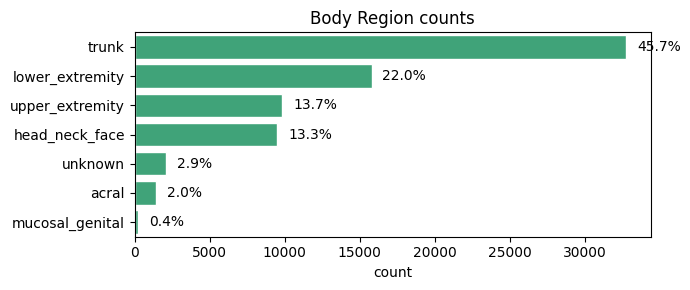

In [14]:
order = df['body_region'].value_counts().index
total = len(df)

plt.figure(figsize=(7, max(3, 0.35*len(order))))
ax = sns.countplot(data=df, y='body_region', order=order,
                   color=plt.cm.viridis(0.65), edgecolor='white')

ax.set_title('Body Region counts')
ax.set_xlabel('count'); ax.set_ylabel('')

# annotate count and % on each bar
for p in ax.patches:
    cnt = int(p.get_width())
    pct = 100 * cnt / total
    ax.text(p.get_width() + max(1, 0.01*total),
            p.get_y() + p.get_height()/2,
            f'{pct:.1f}%',
            va='center')

plt.tight_layout()
plt.show()

## Sex

In [15]:
df['gender'].unique()

array(['female', 'male', 'not_provided'], dtype=object)

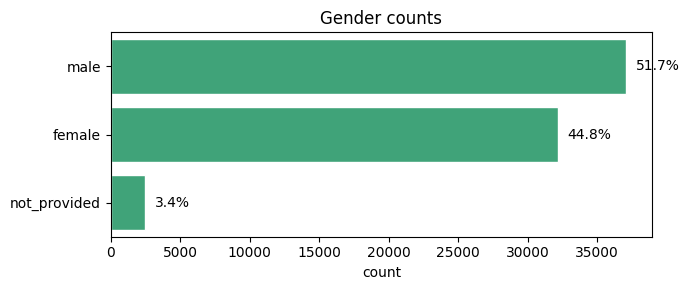

In [16]:
order = df['gender'].value_counts().index
total = len(df)

plt.figure(figsize=(7, max(3, 0.35*len(order))))
ax = sns.countplot(data=df, y='gender', order=order,
                   color=plt.cm.viridis(0.65), edgecolor='white')

ax.set_title('Gender counts')
ax.set_xlabel('count'); ax.set_ylabel('')

# annotate count and % on each bar
for p in ax.patches:
    cnt = int(p.get_width())
    pct = 100 * cnt / total
    ax.text(p.get_width() + max(1, 0.01*total),
            p.get_y() + p.get_height()/2,
            f'{pct:.1f}%',
            va='center')

plt.tight_layout()
plt.show()

## Lesion

In [18]:
df['lesion_type'].unique()

array(['benign', 'malignant', 'no_lesion'], dtype=object)

In [19]:
df['lesion_type'].value_counts()

,count
lesion_type,
benign,52247
malignant,17718
no_lesion,1750


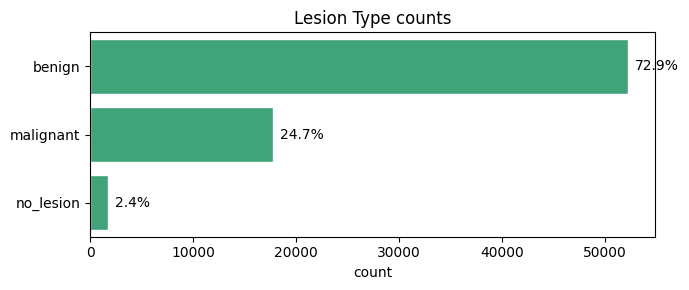

In [21]:
order = df['lesion_type'].value_counts().index
total = len(df)

plt.figure(figsize=(7, max(3, 0.35*len(order))))
ax = sns.countplot(data=df, y='lesion_type', order=order,
                   color=plt.cm.viridis(0.65), edgecolor='white')

ax.set_title('Lesion Type counts')
ax.set_xlabel('count'); ax.set_ylabel('')

# annotate count and % on each bar
for p in ax.patches:
    cnt = int(p.get_width())
    pct = 100 * cnt / total
    ax.text(p.get_width() + max(1, 0.01*total),
            p.get_y() + p.get_height()/2,
            f'{pct:.1f}%',
            va='center')

plt.tight_layout()
plt.show()

## Diagnosis

In [22]:
df['diagnosis'].unique()

array(['NV', 'MEL', 'BKL', 'UNKNOWN', 'DF', 'AKIEC', 'BCC', 'VASC',
       'SCCKA', 'SCC', 'INF', 'BEN_OTH', 'MAL_OTH', 'NO_LESION'],
      dtype=object)

In [23]:
dx_map7 = {
    'NV':'nv', 'MEL':'mel', 'BKL':'bkl', 'BCC':'bcc',
    'AKIEC':'scc_akiec', 'SCC':'scc_akiec', 'SCCKA':'scc_akiec',
    'VASC':'vasc', 'DF':'df',
    'INF':'other_benign', 'BEN_OTH':'other_benign',
    'MAL_OTH':'other_malignant',
    'UNKNOWN':'unknown', 'NO_LESION':'no_lesion'
}

df['dx7'] = df['diagnosis'].map(dx_map7)

In [24]:
df['dx7'].value_counts()

,count
dx7,
unknown,26698
nv,20468
bcc,8453
mel,6165
bkl,4142
scc_akiec,3082
no_lesion,1750
df,389
vasc,386


In [ ]:
order = df['dx7'].value_counts().index
total = len(df)

plt.figure(figsize=(7, max(3, 0.35*len(order))))
ax = sns.countplot(data=df, y='dx7', order=order,
                   color=plt.cm.viridis(0.65), edgecolor='white')

ax.set_title('dx7 counts')
ax.set_xlabel('count'); ax.set_ylabel('')

# annotate count and % on each bar
for p in ax.patches:
    cnt = int(p.get_width())
    pct = 100 * cnt / total
    ax.text(p.get_width() + max(1, 0.01*total),
            p.get_y() + p.get_height()/2,
            f'{pct:.1f}%',
            va='center')

plt.tight_layout()
plt.show()

In [ ]:
print("Unknown share overall:", (df['dx7']=='unknown').mean())

print("\nUnknown share by origin_dataset:")
print((df['dx7']=='unknown').groupby(df['origin_dataset']).mean().sort_values(ascending=False))

print("\nTop filenames with unknown (peek):")
print(df.loc[df['dx7']=='unknown', ['image_id','origin_dataset','lesion']].head(50))

In [ ]:
df.loc[df['dx7']=='unknown', ['lesion']].value_counts()